<h1 style='text-align:center;'>Trabalho - Segmentação de Imagens</h1>

1. Utilizando a base de imagens "folhas.zip" disponibilizada no SIGAA, realize a segmentação das imagens das seguintes formas:

* Aplique o algoritmo K-means utilizando os pixels como pesos, após isso utilize algum detector de borda (à sua escolha);

* Aplique o limiar de Otsu, após isso utilize algum detector de borda (à sua escolha);

* Aplique outro algoritmo de agrupamento que utilize também a posição espacial dos pixels como peso. Após isso utilize algum detector de borda.

In [1]:
from skimage.io import imread, imsave, imshow, imread_collection
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from skimage.filters import threshold_otsu,sobel,roberts,prewitt,scharr
from skimage.segmentation import slic
import glob as g

In [2]:
# Carregando as imagens da base
folhas = g.glob('Folhas/Acer negundo L C/*.jpg')
imgs = imread_collection(folhas)

In [15]:
def aplicaBorda(img):
    borda = roberts(img)
    return borda

def aplicaKmeans(img):
    img = rgb2gray(img)
    X = img.reshape((-1, 1))
    k_means = KMeans(n_clusters=2)
    _ = k_means.fit(X)
    X_clustered = k_means.labels_
    centers = k_means.cluster_centers_.reshape(-1)
    labels = [0., 1.]
    if(centers[0] > centers[1]):
        labels = labels[::-1]
    #X_clustered = X_clustered.reshape(img.shape)
    new_img = np.choose(X_clustered, labels).reshape(img.shape)
    return new_img

def aplicaOtsu(img):
    img = rgb2gray(img)
    thresh = threshold_otsu(img)
    binary = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(img[i][j] > thresh):
                binary[i][j] = 1
            else:
                binary[i][j] = 0
    return binary

def aplicaSuperpixel(img):
    segments = slic(img, n_segments=2, sigma = 5)
    for i in range(segments.shape[0]):
        for j in range(segments.shape[1]):
            if(segments[i][j] == 1):
                segments[i][j] = 0
            else:
                segments[i][j] = 255
    return segments

def run():
    # Para testar os algoritmos de segmentação, basta trocar o nome do método e da imagem a ser salva no for abaixo:
    for i in range(len(imgs)):
        # segmentação
        segmented = aplicaSuperpixel(imgs[i])
        name = (folhas[i].split('/')[-1].split('.')[0] + '_superpixel.jpg')
        plt.imsave('plots_da_atividade_4/superpixel/'+name, segmented, cmap='gray')
        
        #detecção da borda
        borda = aplicaBorda(segmented)
        plt.imsave('plots_da_atividade_4/borda_superpixel/'+name, segmented, cmap='gray')
        print('Segmented {}/{}'.format(i+1, len(imgs)))

# Descomente o método run() para executar essa questão
#run()

In [6]:
# np.random.choice(folhas, 10)

2. Crie um método para escolher o foreground e o background automaticamente.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


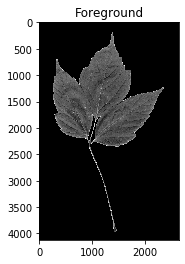

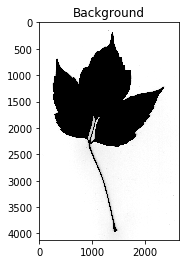

In [7]:
# Apliquei apenas para uma imagem, para fins de exemplo

img = rgb2gray(imgs[0])
segmentedKmeans = aplicaKmeans(img)

foreground = (img - (segmentedKmeans * img))
background = (segmentedKmeans * img)

plt.figure()
plt.title('Foreground')
plt.imshow(foreground,cmap = 'gray')
plt.figure()
plt.title('Background')
plt.imshow(background,cmap = 'gray')

# Salvando
imsave('foreground.png', foreground)
imsave('background.png', background)

3. Pesquise em artigos do estado da arte métricas de acurácia de segmentação. Aplique pelo menos duas métricas nos resultados de segmentação obtidos. Para isso, utilizem as imagens "*_BIN_*" que estão na base.

<i>Obs.: Validei os resultados a partir das segmentações que eu já tinha salvo na questão 1, então para executar essa questão é necessário mudar os caminhos onde as segmentações estão.</i>

In [8]:
# Carregando as máscaras oiginais
bins = g.glob('Folhas/Acer negundo L C/*.bmp')
masks = imread_collection(folhas)

In [16]:
from sklearn.metrics import jaccard_similarity_score, cohen_kappa_score, accuracy_score, f1_score, roc_auc_score

def run():
    acc_sum = 0.
    roc_sum = 0.
    k_sum = 0.
    
    # Para calcular as métricas para os outros métodos, basta alterar o valor da variável method
    
    for i in range(len(masks)):
        mask = rgb2gray(imread(bins[i]))
        mask = mask.astype(int)
        index = bins[i].split('_')[-1].split('.')[0]
        method = 'otsu'
        segmented = imread('plots_da_atividade_4/' + method + '/Acer_N_' + index + '_' + method + '.jpg')
        
        if(method == 'superpixel'):
            segmented = rgb2gray(segmented)
            segmented = segmented.astype(int)
        
        img_true=np.array(mask).ravel()
        img_pred=np.array(segmented).ravel()
        
        # Tive que aplicar um tratamento porque uma das máscaras tem um shape diferente da imagem original
        try:
            acc = accuracy_score(img_true, img_pred)
            roc = roc_auc_score(img_true, img_pred)
            k = cohen_kappa_score(img_true, img_pred)

            print('Imagem {} ==> acc = {}  auc = {}  kappa = {}'.format(i+1, acc, roc, k))
        
            acc_sum += acc
            roc_sum += roc
            k_sum += k
        except Exception as e:
            print(e)
        
    # Exibindo a média dos resultados
    tot = len(bins)-1 #pois uma das imagens tem um shape incorreto
    print()
    print('+==============================+')
    print(method.upper())
    print('+==============================+')
    print('Média das métricas')
    print('+==============================+')
    print('Acurácia: {}'.format(acc_sum/tot))
    print('AUC: {}'.format(roc_sum/tot))
    print('Kappa: {}'.format(k_sum/tot))
    print('+==============================+')

# Descomente o método run() para executar essa questão
# run()

4. Crie um relatório com:

* O embasamento teórico do método de agrupamento escolhido para a segmentação (etapa III da questão 1);

* As saídas das três metodologias de segmentação;

* O detalhamento do método de escolha do fore/back ground;

* Os resultados obtidos com as métricas de avaliação; e

* Uma conclusão explicando qual técnica foi melhor e o motivo.